In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import math
import os
import glob

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [3]:
"""params = {'hidden_dims': (64,), 'batch_size': 157, 'dropout_rate': 0.27396970241049945, 'learning_rate': 1e-07, 'lam': 0.01287687938932214, 'gamma': 0.8332466778517666, 'l2norm_pct': 76, 'max_epochs': 681}

ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=params['hidden_dims'],
    learning_rate=params['learning_rate'],
    dropout_rate=params['dropout_rate'],
    lam=params['lam'],
    gamma=params['gamma'],
    verbose=True,
    max_epochs=params['max_epochs'],
    plot_losses=True,
    dp_sgd=True,
    target_epsilon=1,
    delta=1e-5,
    batch_size=params['batch_size'],
    l2norm_pct=params['l2norm_pct'],
    patience_limit=20,
)
autoencoder = ae.train(X_train, X_train_validate)"""

"params = {'hidden_dims': (64,), 'batch_size': 157, 'dropout_rate': 0.27396970241049945, 'learning_rate': 1e-07, 'lam': 0.01287687938932214, 'gamma': 0.8332466778517666, 'l2norm_pct': 76, 'max_epochs': 681}\n\nae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    hidden_dims=params['hidden_dims'],\n    learning_rate=params['learning_rate'],\n    dropout_rate=params['dropout_rate'],\n    lam=params['lam'],\n    gamma=params['gamma'],\n    verbose=True,\n    max_epochs=params['max_epochs'],\n    plot_losses=True,\n    dp_sgd=True,\n    target_epsilon=1,\n    delta=1e-5,\n    batch_size=params['batch_size'],\n    l2norm_pct=params['l2norm_pct'],\n    patience_limit=20,\n)\nautoencoder = ae.train(X_train, X_train_validate)"

## 2. Test the anomaly detector

In [4]:
"""import numpy as np

# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=params['lam'],
    gamma=params['gamma'],
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
y_pred = detector._detect(scores, np.percentile(scores, 80))

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

'import numpy as np\n\n# Read relevant files\nX_validate = pd.read_feather("../data/processed/X_validate.feather")\ny_validate = pd.read_feather("../data/processed/y_validate.feather")\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=params[\'lam\'],\n    gamma=params[\'gamma\'],\n)\n\n# Compute scores\nscores = detector._compute_anomaly_scores(X_validate)\n\n# Detect\ny_pred = detector._detect(scores, np.percentile(scores, 80))\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)'

## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [5]:
# Epsilon = 1
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 1 --delta 1e-5
# Epsilon = 3
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 3 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=50 --epsilon 3 --delta 1e-5
# Epsilon = 5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=30 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=30 --epsilon 5 --delta 1e-5

### 3.2. Summarize the Performance on Validation Set

In [6]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=True)
    
# Read the log file
log_path = "../logs/dpsgd_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
eval_results = eval_results[(eval_results["epsilon"]>=1)&(eval_results["epsilon"]<=5)]

{'202506071334': ('AUC', 1.0, 1e-05, datetime.datetime(2025, 6, 9, 16, 23, 48, 414277)), '202506070611': ('AUC', 3.0, 1e-05, datetime.datetime(2025, 6, 9, 21, 1, 39, 326931)), '202506070329': ('AUC', 5.0, 1e-05, datetime.datetime(2025, 6, 9, 16, 20, 52, 925064)), '202506081557': ('F1-Score', 1.0, 1e-05, datetime.datetime(2025, 6, 8, 19, 54, 9, 388979)), '202505170526': ('F1-Score', 3.0, 1e-05, datetime.datetime(2025, 5, 22, 4, 24, 59, 226512)), '202506080706': ('F1-Score', 5.0, 1e-05, datetime.datetime(2025, 6, 8, 16, 22, 51, 917467)), '202506090641': ('Recall', 1.0, 1e-05, datetime.datetime(2025, 6, 9, 14, 17, 24, 697934)), '202506082214': ('Recall', 3.0, 1e-05, datetime.datetime(2025, 6, 9, 1, 6, 43, 560345)), '202506081954': ('Recall', 5.0, 1e-05, datetime.datetime(2025, 6, 8, 22, 14, 32, 227245)), '202506091623': ('Precision', 3.0, 1e-05, datetime.datetime(2025, 6, 9, 18, 56, 47, 563543)), '202506091417': ('Precision', 5.0, 1e-05, datetime.datetime(2025, 6, 9, 16, 20, 52, 925064)),

In [7]:
display(eval_results.sort_values(by=["tuned_by", "epsilon"], ascending=True))#[['epsilon', 'tuned_by']])

,precision,recall,f1_score,auc,accuracy,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,l2norm_pct,max_epochs,threshold,q,tuned_by,delta,epsilon,end_time
version,,,,,,,,,,,,,,,,,,,
202506091856,0.732558,0.218655,0.336786,0.698917,0.826743,"(64,)",114.0,0.207187,0.001527,0.026076,0.304933,80.0,204.0,10.942133,0.94,Precision,0.00001,1.0,2025-06-09 21:06:36.189807
202506091623,0.728198,0.217354,0.334781,0.697536,0.826220,"(64,)",64.0,0.328941,0.003784,0.068106,0.954600,93.0,682.0,1.757909,0.94,Precision,0.00001,3.0,2025-06-09 18:56:47.563543
202506091417,0.742733,0.221692,0.341463,0.697957,0.827965,"(64, 32)",75.0,0.299793,0.009656,0.099589,0.889140,85.0,665.0,3.958586,0.94,Precision,0.00001,5.0,2025-06-09 16:20:52.925064
202506090641,0.410823,0.612581,0.491815,0.755774,0.745309,"(64,)",67.0,0.333740,0.001203,0.082912,0.999000,85.0,421.0,0.307921,0.70,Recall,0.00001,1.0,2025-06-09 14:17:24.697934
202506082214,0.367763,0.548373,0.440265,0.703185,0.719473,"[64, 32]",128.0,0.102304,0.003005,0.009587,0.162606,80.0,390.0,4.313924,0.70,Recall,0.00001,3.0,2025-06-09 01:06:43.560345
202506081954,0.408787,0.609544,0.489377,0.754388,0.744087,"(64, 32)",127.0,0.118356,0.001347,0.043012,0.996738,94.0,207.0,0.400868,0.70,Recall,0.00001,5.0,2025-06-08 22:14:32.227245
202506081557,0.483142,0.528416,0.504766,0.758504,0.791394,"(64,)",91.0,0.281101,0.000158,0.065214,0.988206,87.0,663.0,0.950255,0.78,F1-Score,0.00001,1.0,2025-06-08 19:54:09.388979
202505170526,0.542145,0.471584,0.504408,0.741209,0.813564,"[64, 32]",78.0,0.061674,0.000010,0.010771,0.999000,79.0,700.0,1.726553,NaN,F1-Score,0.00001,3.0,2025-05-22 04:24:59.226512
202506080706,0.519367,0.413015,0.460126,0.712384,0.805010,[64],66.0,0.173445,0.007265,0.013548,0.139324,80.0,322.0,5.370908,0.84,F1-Score,0.00001,5.0,2025-06-08 16:22:51.917467


In [8]:
eval_results.to_csv("../experiments/perf_summary/dpsgd_val_results.csv")

### 3.3. Compare Models Based on Validation Set

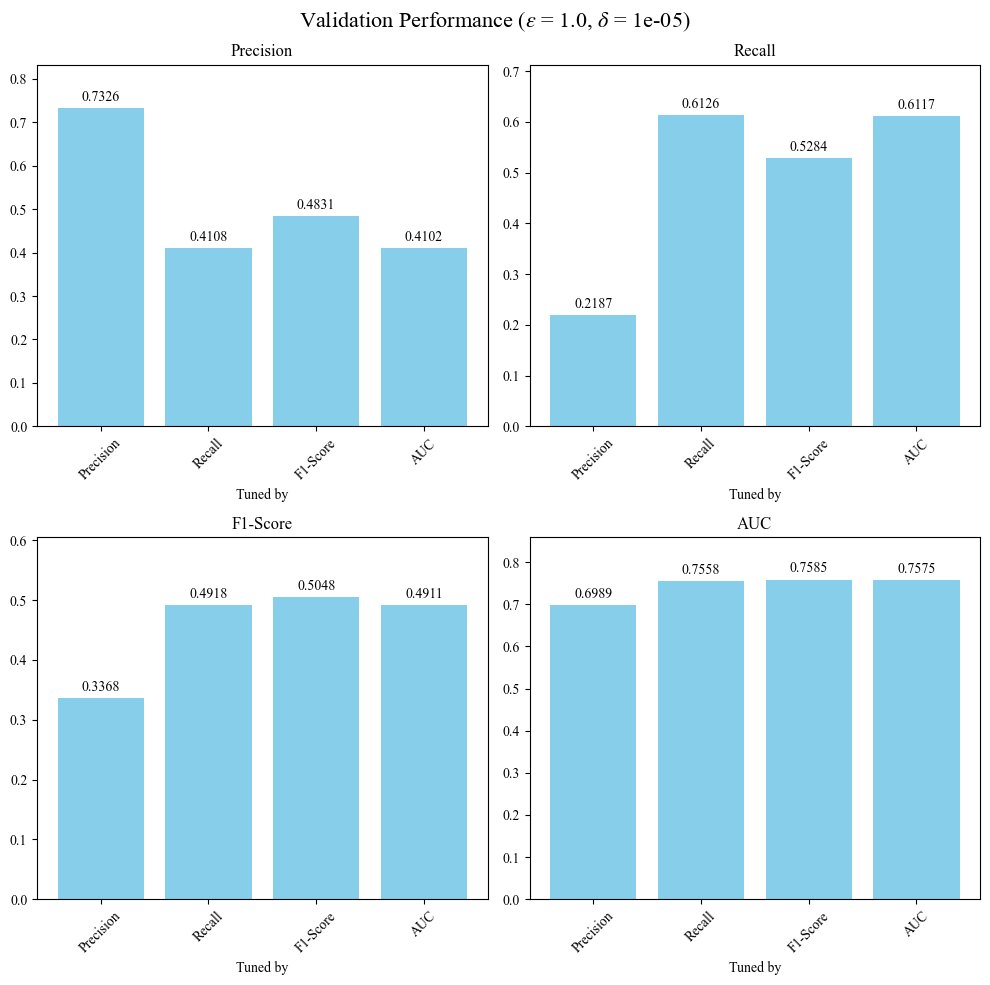

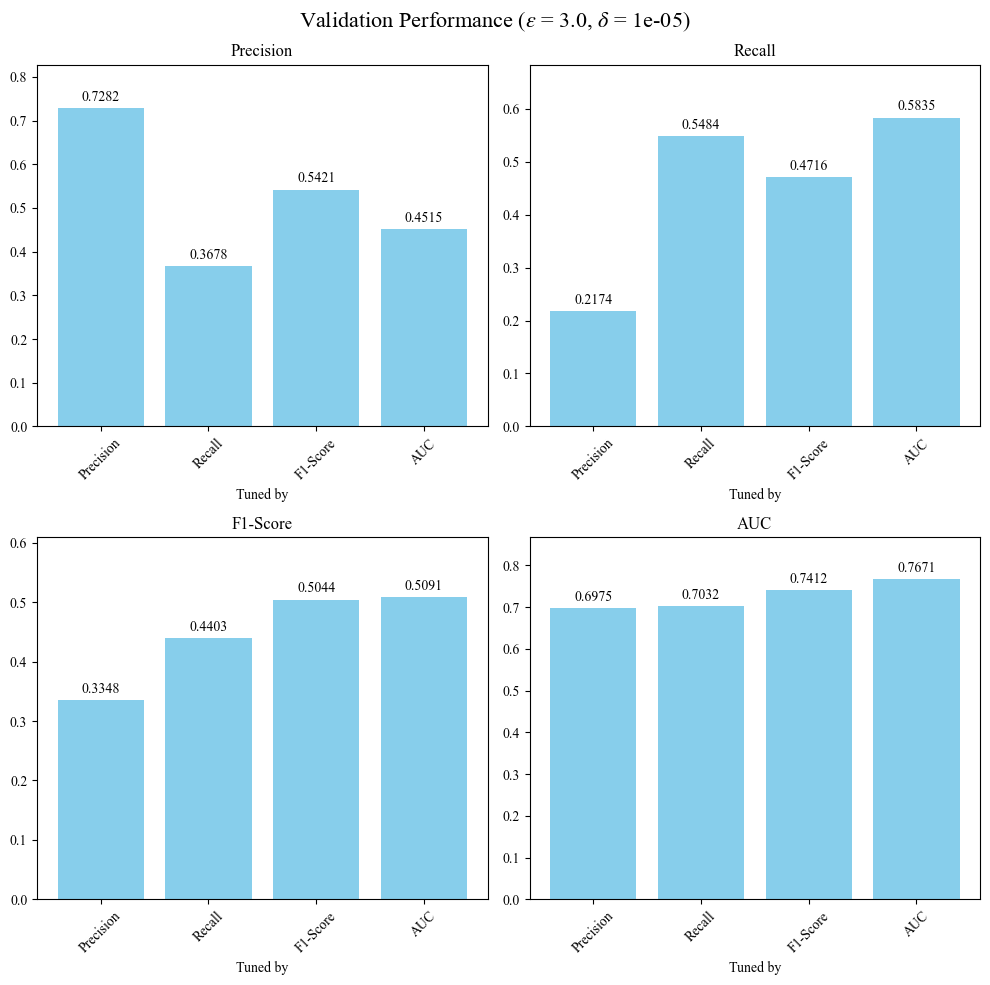

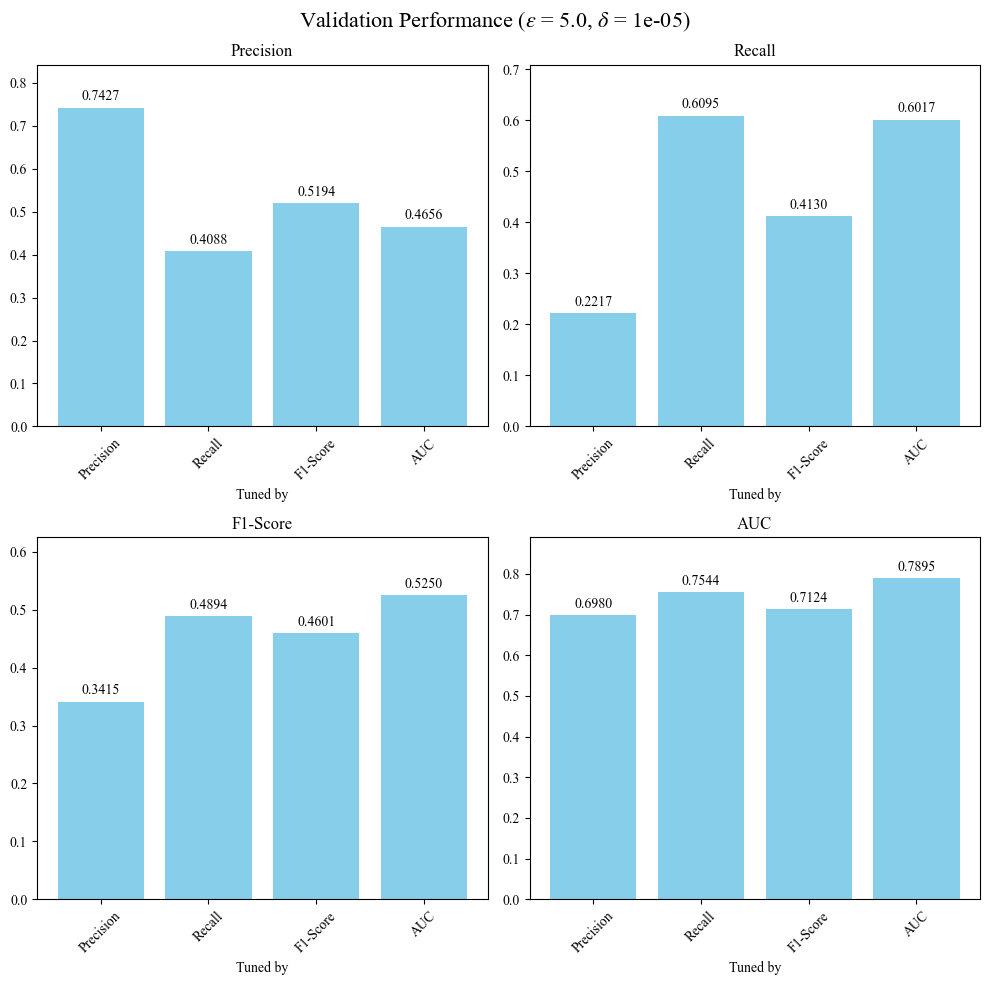

In [9]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

### 3.4. Inspect Convergence of Bayesian Optimization

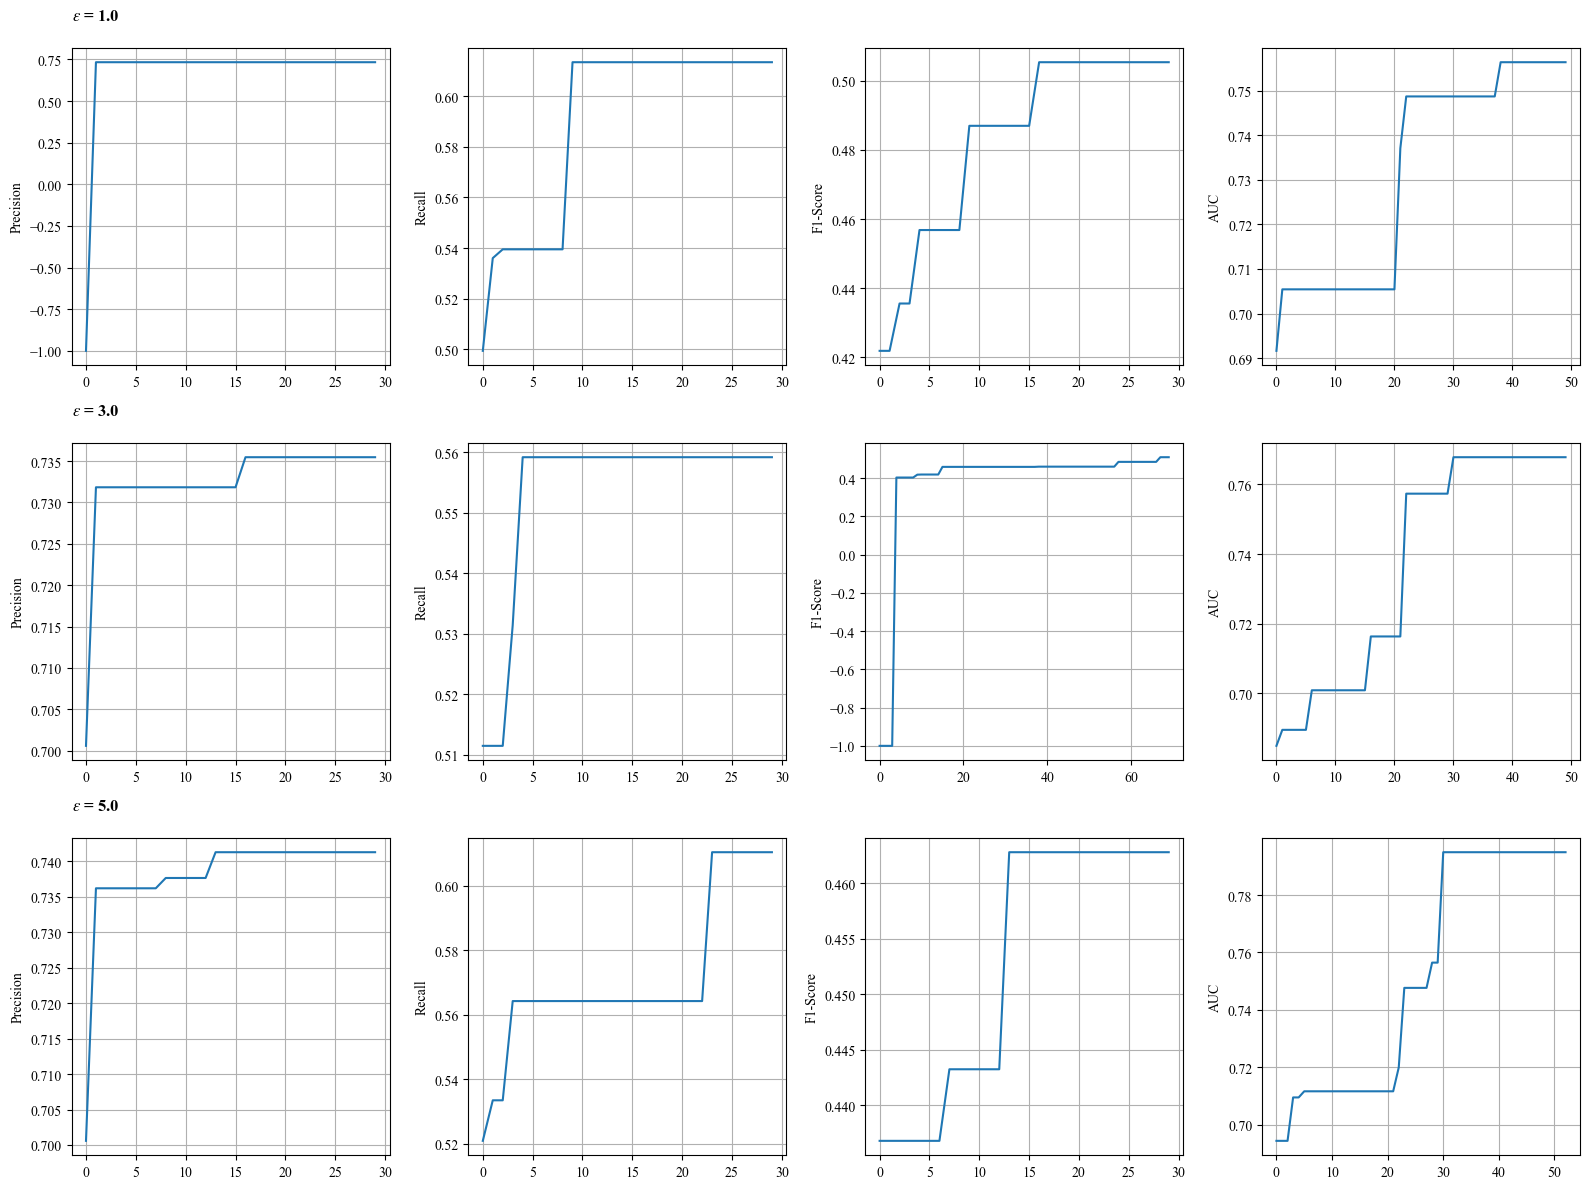

In [10]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax = axes[i]
    metric = row["tuned_by"].lower().replace("-", "_")
    version = row["version"]
    epsilon = row["epsilon"]

    # Read result file
    results_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")
    results_df["best_so_far"] = results_df[metric].cummax()

    # Plot
    ax.plot(results_df.index, results_df["best_so_far"])
    ax.set_ylabel(row["tuned_by"])
    ax.grid(True)

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=20)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.5. Check Convergence of the Final Training

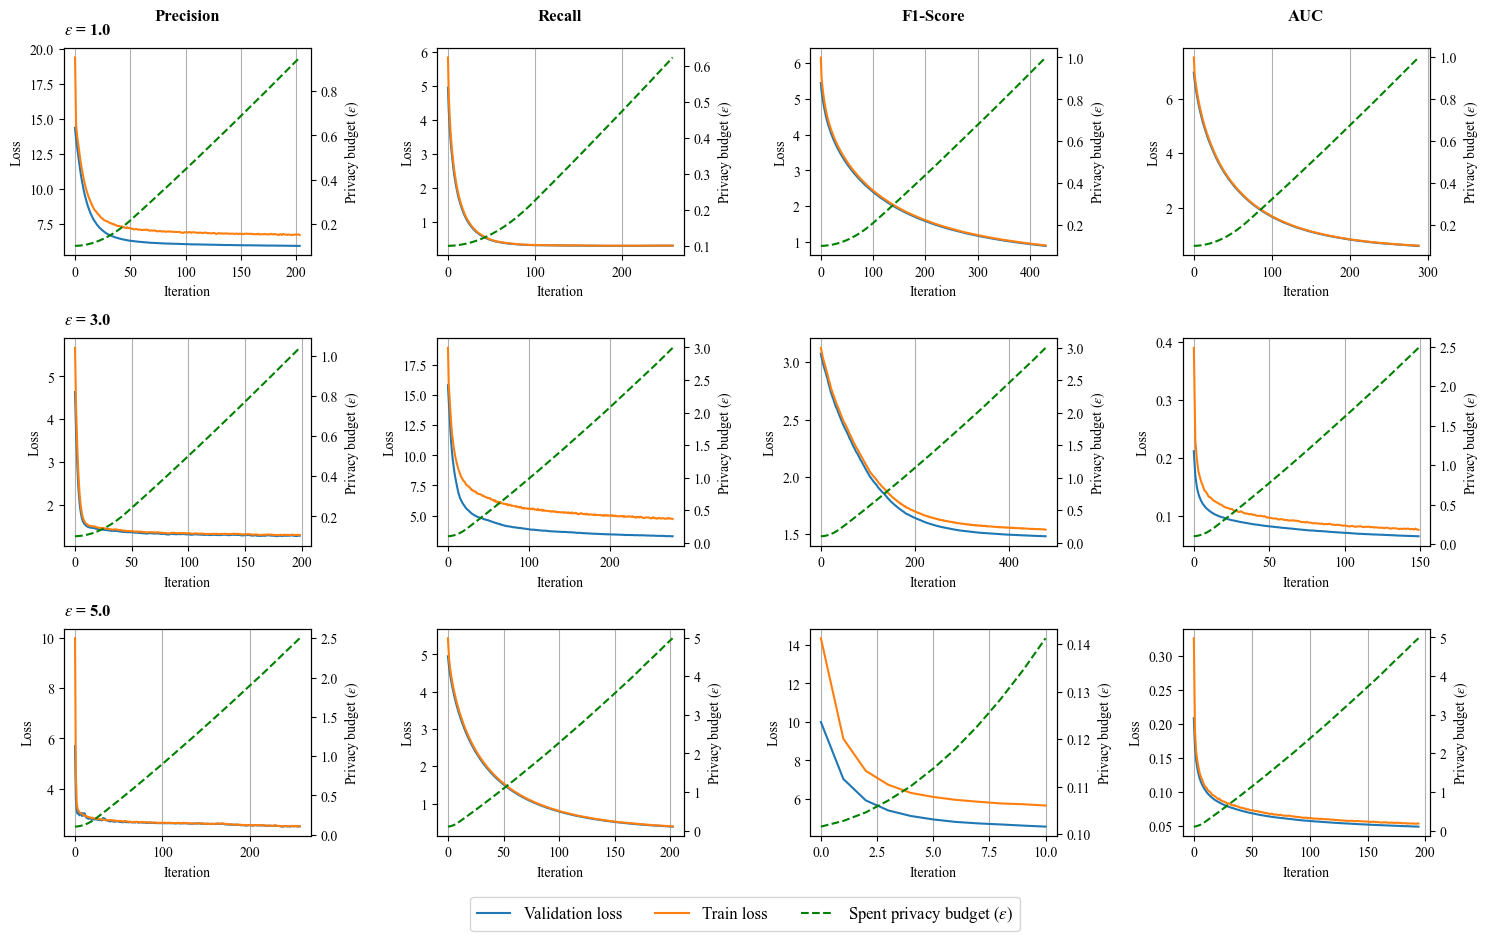

In [11]:
# Sort and reset index for consistent iteration
sorted_results = eval_results.sort_values(by=["epsilon"], ascending=True).reset_index()

# Set up grid
n_cols = 4
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax1 = axes[i]
    # Create second y-axis sharing the same x-axis
    ax2 = ax1.twinx()
    version = row["version"]
    epsilon = row["epsilon"]
    metric = row["tuned_by"]

    # Read result file
    folder = "../experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_noise*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)

    # Plot loss on the left y-axis
    val = ax1.plot(results_df.index, results_df["val_loss"], label='Validation loss')
    train = ax1.plot(results_df.index, results_df["train_loss"], label='Train loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y')

    # Plot epsilon on the right y-axis
    priv = ax2.plot(results_df.index, results_df["spent_eps"], label=r'Spent privacy budget ($\varepsilon$)', color='g', linestyle='--')
    ax2.set_ylabel(r'Privacy budget ($\varepsilon$)')
    ax2.tick_params(axis='y')

    # added these three lines
    lns = val + train + priv
    labs = [l.get_label() for l in lns]
    
    # Set grid for x-axis
    ax1.grid(True, axis='x')

    # Set a title specific to each subplot
    if i // n_cols == 0:
        ax2.set_title(f"{metric}", fontsize=12, pad=20, fontweight='bold')

    # If it's the first column in a row, set a title for that row
    if i % n_cols == 0:
        ax1.set_title(f"$\\varepsilon$ = {epsilon}", loc='left', fontsize=12, fontweight='bold', pad=10)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(lns, labs, loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=3, fontsize=12)

plt.tight_layout()
plt.show()

In [12]:
# Filter and pivot to prepare LaTeX table data
selected_metrics = ["precision", "recall", "f1_score", "auc"]
df_filtered = eval_results[eval_results["tuned_by"].isin(["Precision", "Recall", "F1-Score", "AUC"])]
df_filtered = df_filtered[df_filtered["epsilon"].isin([1.0, 3.0, 5.0])]
df_filtered["tuned_by"] = df_filtered["tuned_by"].str.replace("F1-Score", "F1-score")

# Group and find best metrics for each (epsilon, tuned_by)
def format_row(row, max_vals):
    return " & ".join([
        f"\\textbf{{{row[m]*100:.3f}}}" if row[m] == max_vals[m] else f"{row[m]*100:.3f}"
        for m in selected_metrics
    ])

latex_rows = []
for i, eps in enumerate(sorted(df_filtered["epsilon"].unique())):
    group = df_filtered[df_filtered["epsilon"] == eps]
    latex_rows.append(f"\\multirow[t]{{4}}{{*}}{{{eps}}}")
    for obj in ["Precision", "Recall", "F1-score", "AUC"]:
        row = group[group["tuned_by"] == obj]
        if row.empty:
            latex_rows.append(f"& {obj} & -- & -- & -- & -- \\\\")
        else:
            row = row.iloc[0]
            max_vals = group[selected_metrics].max()
            metrics_str = format_row(row, max_vals)
            latex_rows.append(f"& {obj} & {metrics_str} \\\\")
    if i < len(sorted(df_filtered["epsilon"].unique())) - 1:
        latex_rows.append("\\midrule")

# Compose the full LaTeX table
latex_table = r"""
\begin{table}[!t]
    \centering
    \caption{Validation performance (\%) of DP-SGD models under different tuning objectives and privacy levels ($\delta = 10^{-5}$)}
    \label{tab:dpsgd-validation}
    \begin{tabular}{clcccc}
    \toprule
    $\boldsymbol{\varepsilon}$ & \textbf{Tuning Objective} & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{AUC} \\
    \midrule
    """ + "\n\t".join(latex_rows) + r"""
    \bottomrule
    \end{tabular}
    \vspace{2mm}
    \caption*{\footnotesize Validation performance of DP-SGD models is reported as percentages under four tuning objectives (Precision, Recall, F1-score, and AUC) and four privacy budgets ($\varepsilon \in \{0.5, 1, 3, 5\}$), with fixed $\delta = 10^{-5}$. The rows indicate the objective used during tuning; the columns report the resulting performance on each metric. All values are in percentage points. The highest value for each $\varepsilon$-specific group is highlighted in bold. Final hyperparameter configurations are provided in Appendix~\ref{a:hyper_select}.}
\end{table}
"""

print(latex_table)


\begin{table}[!t]
    \centering
    \caption{Validation performance (\%) of DP-SGD models under different tuning objectives and privacy levels ($\delta = 10^{-5}$)}
    \label{tab:dpsgd-validation}
    \begin{tabular}{clcccc}
    \toprule
    $\boldsymbol{\varepsilon}$ & \textbf{Tuning Objective} & \textbf{Precision} & \textbf{Recall} & \textbf{F1-score} & \textbf{AUC} \\
    \midrule
    \multirow[t]{4}{*}{1.0}
	& Precision & \textbf{73.256} & 21.866 & 33.679 & 69.892 \\
	& Recall & 41.082 & \textbf{61.258} & 49.181 & 75.577 \\
	& F1-score & 48.314 & 52.842 & \textbf{50.477} & \textbf{75.850} \\
	& AUC & 41.024 & 61.171 & 49.112 & 75.751 \\
	\midrule
	\multirow[t]{4}{*}{3.0}
	& Precision & \textbf{72.820} & 21.735 & 33.478 & 69.754 \\
	& Recall & 36.776 & 54.837 & 44.026 & 70.318 \\
	& F1-score & 54.214 & 47.158 & 50.441 & 74.121 \\
	& AUC & 45.149 & \textbf{58.351} & \textbf{50.908} & \textbf{76.708} \\
	\midrule
	\multirow[t]{4}{*}{5.0}
	& Precision & \textbf{74.273} & 22.169 & 34